# Mini Lab 01: Texts, Algorithms, and Black-boxes

We're going to start by unpacking the controversy regarding the **syuzhet** package—originally developed for R by Matthew Jockers, and now available in Python as **moodswing**.

This is a useful exercise because it gets to some foundational issues in text analysis. These are questions you're going to encounter in your work, so they're worth considering from the beginning:

- **How much do we know about what's happening "under the hood"?**
- **How much *should* we know?**
- **Is showing that *Madame Bovary* has a downward emotional arc even interesting** (even though it looks cool)?
- **Can we take something like narrative arcs and apply them to genuinely interesting research questions?**

**Key readings** (available on Canvas):
- Annie Swafford's critique: [Why Syuzhet Doesn't Work](https://perma.cc/TYT3-5DTU)
- Jockers' response: [Matthew Jockers' blog (archived)](https://web.archive.org/web/20190708100723/http://www.matthewjockers.net/page/2/)

This mini lab will also serve as an **introduction to Google Colab** and working with Python for text analysis.

## Install Packages

First, we'll install the `moodswing` package. The `%%capture` magic suppresses installation output to keep things clean.

In [1]:
%%capture
!pip install moodswing

## Import Libraries

Now we'll import the libraries we need for sentiment analysis and visualization.

In [2]:
# Sentiment analysis and narrative trajectories
from moodswing import (
    DictionarySentimentAnalyzer,
    Sentencizer,
    DCTTransform,
    prepare_trajectory,
    plot_trajectory
)
from moodswing.data import load_sample_text

# Data manipulation and visualization
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

## Load Data

The novels that Jockers uses as examples are included in the `moodswing` package. There are 4 novels available:

- `madame_bovary` - Gustave Flaubert
- `portrait_artist` - James Joyce
- `ragged_dick` - Horatio Alger
- `silas_lapham` - William Dean Howells

For this demonstration, we'll be using *Madame Bovary*.

In [3]:
# Load Madame Bovary
doc_id, text = load_sample_text("madame_bovary")

print(f"Loaded: {doc_id}")
print(f"Length: {len(text):,} characters")

Loaded: madame_bovary
Length: 648,257 characters


## Prep the Data and Calculate Sentiment

Next, we'll split the novel into sentences and calculate a sentiment score for each sentence using the **Syuzhet** lexicon (the same dictionary used in the original R package).

In [4]:
# Split text into sentences
sentencizer = Sentencizer()
sentences = sentencizer.split(text)

print(f"Number of sentences: {len(sentences):,}")

Number of sentences: 6,943


Now we'll score each sentence using the Syuzhet lexicon:

In [5]:
# Create sentiment analyzer
analyzer = DictionarySentimentAnalyzer()

# Calculate sentiment scores for each sentence
# method="syuzhet" uses the same dictionary as the original R package
scores = analyzer.sentence_scores(sentences, method="syuzhet")

print(f"First 10 scores: {scores[:10]}")

First 10 scores: [1.2000000000000002, 0.25, 0.0, 1.5, 1.05, 1.2000000000000002, 1.0, -0.25, 0.0, 0.4]


Let's examine these scores in a DataFrame for easier inspection:

In [6]:
# Create a dataframe to view scores
df_scores = pl.DataFrame({
    "sentence_num": range(1, len(scores) + 1),
    "sentiment": scores,
    "sentence": sentences
})

# View first 10 rows
print(df_scores.head(10))

shape: (10, 3)
┌──────────────┬───────────┬─────────────────────────────────┐
│ sentence_num ┆ sentiment ┆ sentence                        │
│ ---          ┆ ---       ┆ ---                             │
│ i64          ┆ f64       ┆ str                             │
╞══════════════╪═══════════╪═════════════════════════════════╡
│ 1            ┆ 1.2       ┆ Part I Chapter One We were in … │
│ 2            ┆ 0.25      ┆ Those who had been asleep woke… │
│ 3            ┆ 0.0       ┆ The head-master made a sign to… │
│ 4            ┆ 1.5       ┆ Then, turning to the class-mas… │
│ 5            ┆ 1.05      ┆ If his work and conduct are sa… │
│ 6            ┆ 1.2       ┆ The "new fellow," standing in … │
│ 7            ┆ 1.0       ┆ His hair was cut square on his… │
│ 8            ┆ -0.25     ┆ Although he was not broad-shou… │
│ 9            ┆ 0.0       ┆ His legs, in blue stockings, l… │
│ 10           ┆ 0.4       ┆ We began repeating the lesson.  │
└──────────────┴───────────┴────────────

## Transforming the Data with DCT

The next step is to transform the data using the **Discrete Cosine Transform (DCT)**.

Originally, Jockers used a Fourier transformation, which he described as follows:

> Aaron introduced me to a mathematical formula from signal processing called the Fourier transformation. The Fourier transformation provides a way of decomposing a time based signal and reconstituting it in the frequency domain. A complex signal (such as the one seen above in the first figure in this post) can be decomposed into series of symmetrical waves of varying frequencies. And one of the magical things about the Fourier equation is that these decomposed component sine waves can be added back together (summed) in order to reproduce the original wave form–this is called a backward or reverse transformation. Fourier provides a way of transforming the sentiment-based plot trajectories into an equivalent data form that is independent of the length of the trajectory from beginning to end. The frequency domain begins to solve the book length problem.

This introduced some unwanted outcomes, namely that the resulting wave-forms must begin and end at the same point. The updated approach uses a **Discrete Cosine Transform (DCT)**, which is commonly used in data compression (like JPEG images and MP3 audio).

If you're interested, there's [a detailed explanation here with examples](http://datagenetics.com/blog/november32012/index.html).

### Apply DCT Transformation

In [8]:
# Apply DCT transformation
# low_pass_size: how much smoothing (lower = more smoothing)
# output_length: standardize to this many points
# scale_range: normalize to [-1, 1]

trajectory = prepare_trajectory(
    scores,
    rolling_window=None,  # Optional: can add moving average first
    dct_transform=DCTTransform(
        low_pass_size=5,
        output_length=100,
        scale_range=True
    )
)

print(f"Original scores: {len(scores)}")
print(f"Transformed trajectory: {len(trajectory.dct)}")
print(f"\nFirst 10 transformed values:")
print(trajectory.dct[:10])

Original scores: 6943
Transformed trajectory: 100

First 10 transformed values:
[1.         0.99718023 0.99156374 0.9831964  0.9721465  0.95850405
 0.94237997 0.92390505 0.90322867 0.88051744]


/var/folders/5y/_jt611y92qv80hh6jwzmjt940000gn/T/ipykernel_44101/2615735359.py:6: UserWarning: DCT transform already has scaling enabled (scale_range=True, scale_values=False). Skipping additional normalization of DCT output to prevent double-scaling. Raw and rolling components are still normalized.
  trajectory = prepare_trajectory(


Let's view the trajectory data in a DataFrame:

In [9]:
# Create DataFrame for trajectory
df_trajectory = pl.DataFrame({
    "time": range(1, len(trajectory.dct) + 1),
    "dct": trajectory.dct
})

print(df_trajectory.head(10))

shape: (10, 2)
┌──────┬──────────┐
│ time ┆ dct      │
│ ---  ┆ ---      │
│ i64  ┆ f64      │
╞══════╪══════════╡
│ 1    ┆ 1.0      │
│ 2    ┆ 0.99718  │
│ 3    ┆ 0.991564 │
│ 4    ┆ 0.983196 │
│ 5    ┆ 0.972146 │
│ 6    ┆ 0.958504 │
│ 7    ┆ 0.94238  │
│ 8    ┆ 0.923905 │
│ 9    ┆ 0.903229 │
│ 10   ┆ 0.880517 │
└──────┴──────────┘


## Visualize the Emotional Arc

Finally, we can plot the transformed sentiment trajectory:

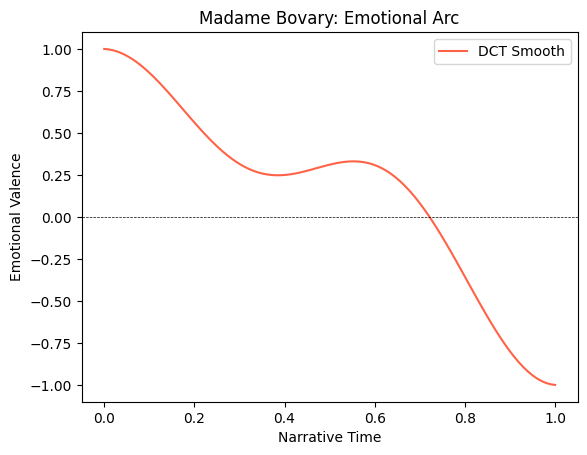

In [10]:
# Simple plot using moodswing's built-in function
plot_trajectory(
    trajectory,
    title="Madame Bovary: Emotional Arc",
    components=["dct"],  # Only show DCT-transformed trajectory
    colors={"dct": "tomato"}
)
plt.xlabel("Narrative Time")
plt.ylabel("Emotional Valence")
plt.show()

## Transformed vs. Non-Transformed Data

To better understand what the DCT is doing, let's compare the raw sentence-level scores with the smoothed trajectory.

First, we'll create a normalized version of the raw scores:

In [11]:
# Normalize raw scores to same scale as DCT output
raw_sentiment = np.array(scores)
raw_normalized = 2 * (raw_sentiment - raw_sentiment.min()) / (raw_sentiment.max() - raw_sentiment.min()) - 1

# Create normalized time values (as percentages)
raw_time = np.arange(len(raw_sentiment)) / len(raw_sentiment) * 100

# DCT time values
dct_time = np.arange(len(trajectory.dct)) / len(trajectory.dct) * 100

Now plot both together:

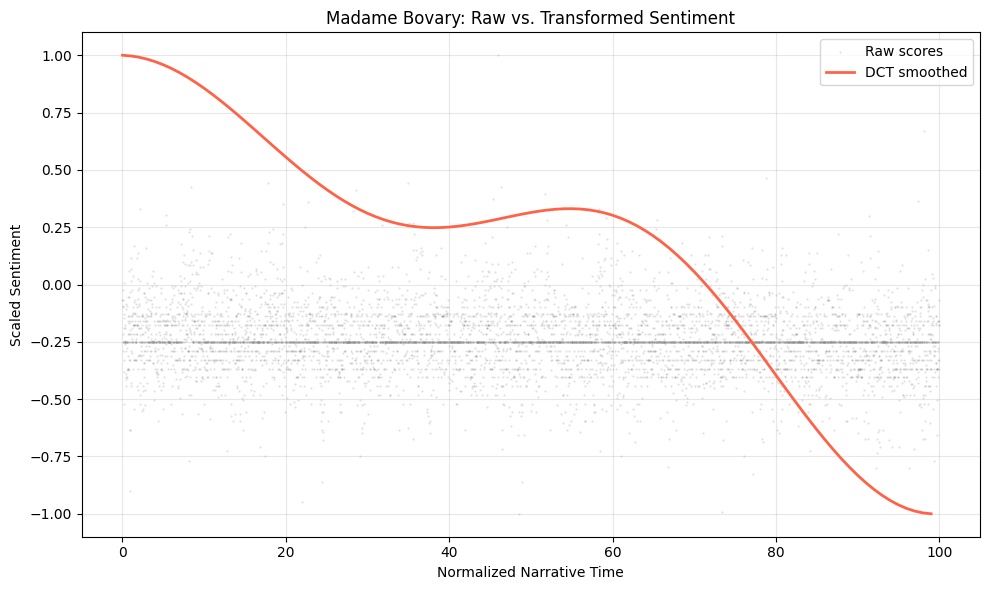

In [12]:
plt.figure(figsize=(10, 6))

# Plot raw scores as scatter points
plt.scatter(raw_time, raw_normalized, alpha=0.25, s=0.25, color='gray', label='Raw scores')

# Plot DCT trajectory as line
plt.plot(dct_time, trajectory.dct, color='tomato', linewidth=2, label='DCT smoothed')

plt.xlabel('Normalized Narrative Time')
plt.ylabel('Scaled Sentiment')
plt.title('Madame Bovary: Raw vs. Transformed Sentiment')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Discussion Questions

Some questions to consider as you look at these visualizations:

### Critical Interpretation

1. **Look at the comparison plot carefully.** The gray points are the *actual* sentiment scores from the text. The red line is what DCT produces.
   - Is the red line **revealing** an underlying pattern that was hidden in the noisy data?
   - Or is it **imposing** a smooth curve that makes the data look more structured than it really is?

2. **What is the distinction Schmidt makes between "algorithms" and "transformations"?**
   - Is this a useful distinction to make, do you think?

3. **What are the main critiques of Jockers' syuzhet package?**
   - Which critiques seem most compelling to you?
   - Are there any you disagree with?

### Method and Meaning

4. **Does this curve tell us something *meaningful* about *Madame Bovary*?**
   - Or is it just a pretty picture?
   - What would make it meaningful vs. just decorative?

5. **How much do we need to know about what's happening "under the hood"?**
   - Can you use this method effectively without understanding DCT?
   - What level of understanding is "enough"?

6. **What questions, if any, does the reading raise for you?**

### Research Applications

7. **Can you think of a research question where sentiment trajectories might be genuinely useful?**
   - What would you need to compare or measure?
   - How many texts would you need?
   - What would "count" as a meaningful finding?

## 🧪 Try It Yourself

Experiment with the code above by:

1. **Loading a different novel** (change `"madame_bovary"` to one of the other options)
2. **Adjusting the smoothing** (try different values for `low_pass_size` - smaller = smoother)
3. **Changing the output length** (try `output_length=50` or `output_length=200`)

Do different novels show different emotional arcs? Do different smoothing parameters change your interpretation?

## Key Takeaways

1. **Computational methods are not neutral** - They make assumptions and can impose structure
2. **Be critical of smooth visualizations** - They may be revealing patterns *or* creating them
3. **Understanding matters** - You need to know what methods do, even if not the full mathematics
4. **Context is essential** - A single curve doesn't mean much without comparative data
5. **Tools enable questions** - Use methods to explore interesting problems, not just to make pretty graphs

This controversy from 2015 is still relevant because these issues apply to *all* computational humanities work: text classification, topic modeling, word embeddings, and more. The questions don't go away—**how much do we know, how much should we know, and what counts as a meaningful finding?**